# Laboratory work 5
<b>NN architecture:</b> U-Net <br/>
<b>Optimizer:</b> SGD, Adam <br/>
<b>Dataset:</b> CityScapes <br/>
<b>link to dataset on kaggle:</b> https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/ <br/>
<b>link to dataset on source website:</b> https://www.cityscapes-dataset.com/

# About Dataset
## Context
Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.
## Content
This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.
## Acknowledgements
This dataset is the same as what is available here from the Berkeley AI Research group.
## Features
### Polygonal annotations
- Dense semantic segmentation
- Instance segmentation for vehicle and people

### Complexity
- 30 classes

### Diversity
- 50 cities
- Several months (spring, summer, fall)
- Daytime
- Good/medium weather conditions
- Manually selected frames
    - Large number of dynamic objects
    - Varying scene layout
    - Varying background
    
### Volume
- 5 000 annotated images with fine annotations (examples)
- 20 000 annotated images with coarse annotations (examples)


# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics
import random
import math
import os
import gc
import cv2
import PIL
import time

from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Reproducibility

In [3]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_validate= torch.Generator().manual_seed(1)
g_test = torch.Generator().manual_seed(2)

In [4]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
RAND_CONST = 10

# Data read
## Custom semantic segmentation dataset class

In [5]:
class SemanticSegmentationDataset(torch.utils.data.Dataset):
    # id_map that maps approximate RGB code to int label
    # source: https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
    id_map = {
        0: (0, 0, 0),      # static
        1: (128, 64,128),  # road
        2: (244, 35,232),  # sidewalk
        3: (250,170,160),  # parking
        4: (230,150,140),  # rail track
        5: (220, 20, 60),  # person
        6: (255, 0, 0),    # rider
        7: (0, 0,142),     # car
        8: (0, 0, 70),     # truck
        9: (0, 60,100),    # bus
        10: (0, 80, 100),  # on rails
        11: (0, 0, 90),    # caravan
        12: (0, 0, 110),   # trailer
        13: (0, 0, 230),   # motorcycle
        14: (119, 11, 32), # bicycle
        15: ( 70, 70, 70), # building
        16: (102,102,156), # wall
        17: (190,153,153), # fence
        18: (180,165,180), # guard rail
        19: (150,100,100), # bridge
        20: (150,120, 90), # tunnel
        21: (153,153,153), # pole or polegroup
        22: (250,170, 30), # traffic light
        23: (220,220, 0),  # traffic sign
        24: (107,142, 35), # vegetation
        25: (152,251,152), # terrain
        26: (70,130,180),  # sky
        27: (111, 74, 0),  # dynamic
        28: (81, 0, 81)   # ground
    }
    
    def __init__(self, folder_path, resize, saved_masks_path=None, transformer=None):
        self.folder_path = folder_path # path to dataset
        self.transformer = transformer # transformer applied to images (not masks)
        self.resize_transformer = transforms.Resize((resize, resize)) # resize parameter controls size of images and masks
        self.saved_masks_path = saved_masks_path # path to processed masks (if exists)
        self.image_list = self._load_image_list() # load list of all images in dataset folder
        self.images = []
        if saved_masks_path is None: # in case if there is no processed masks they are created
            self.masks = []
        self.image_masks = []
        self._load_images_and_masks() # read images, masks and process masks

    def _load_image_list(self):
        # load list of all images in dataset folder
        return [f for f in os.listdir(self.folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    def _load_images_and_masks(self):
        for idx in tqdm(range(len(self.image_list))):
            image_path = os.path.join(self.folder_path, self.image_list[idx])
            merged_image = PIL.Image.open(image_path).convert('RGB') # open image, where left path
            # is original image and right path is it's mask

            original_width = merged_image.width // 2 # get the width of the original image

            # Crop the original and mask parts
            original_image = merged_image.crop((0, 0, original_width, merged_image.height))
            if self.transformer is None:
                original_image = np.array(self.resize_transformer(original_image))
            else:
                original_image = self.transformer(original_image).numpy()
            
            image_mask = merged_image.crop((original_width, 0, merged_image.width, merged_image.height))
            image_mask = np.array(self.resize_transformer(image_mask))
                
            self.images.append(original_image)
            self.image_masks.append(image_mask)

            if self.saved_masks_path is None:
                # create mask in form of 2d array of labels from mask in the image format
                mask = np.zeros(shape=(image_mask.shape[0], image_mask.shape[1]), dtype = np.uint8)
                for row in range(mask.shape[0]):
                    for col in range(mask.shape[1]):
                        a = image_mask[row, col, :]
                        final_key = None
                        final_d = None
                        # find label with the most appropriate RGB code
                        for key, value in SemanticSegmentationDataset.id_map.items():
                            d = np.sum(np.abs(a - value))
                            if final_key == None:
                                final_d = d
                                final_key = key
                            elif d < final_d:
                                final_d = d
                                final_key = key
                        mask[row, col] = final_key
                self.masks.append(mask)
            
        self.images = torch.tensor(np.array(self.images))
        self.image_masks = np.array(self.image_masks)
        
        if self.saved_masks_path is not None:
            self.masks = torch.tensor(np.load(self.saved_masks_path), dtype=torch.long)
        else:
            if len(self.image_list) <= 1000:
                np.save("masks_array_val.npy", np.array(self.masks))
            else:
                np.save("masks_array_train.npy", np.array(self.masks))
            self.masks = torch.tensor(self.masks, dtype=torch.long)
        
            
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]
    
    def get_mask_image(self, idx):
        return PIL.Image.fromarray(self.image_masks[idx]) # get mask in the image format
    
    def __array__(self):
        # Convert the dataset to a NumPy array representation
        return self.images
    
    def mean(self, axis=(0, 1, 2)):
        # Calculate mean for the dataset
        return np.mean(self.__array__().numpy() / 255, axis=axis)

    def std(self, axis=(0, 1, 2)):
        # Calculate standard deviation for the dataset
        return np.std(self.__array__().numpy()  / 255, axis=axis)

## Convert masks from image to arrays of labels

In [6]:
# # Create masks in the format of 2d array of labels
# dataset_train = SemanticSegmentationDataset(folder_path="/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/", resize=128)
# del dataset_train
# gc.collect()
# dataset_val = SemanticSegmentationDataset(folder_path="/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/", resize=128)
# del dataset_val
# gc.collect()

In [7]:
def visualize_segmentation(discrete_mask):
    """ Convert mask in the format of 2d array of labels to image """
    # Create an empty RGB image with the same shape as discrete_mask
    height, width = discrete_mask.shape
    output_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Map each pixel value in discrete_mask to the corresponding RGB color from id_map
    for i in range(height):
        for j in range(width):
            pixel_value = discrete_mask[i, j]
            output_image[i, j, :] = SemanticSegmentationDataset.id_map[pixel_value.item()]

    # Convert the NumPy array to a Pillow Image
    output_image = PIL.Image.fromarray(output_image)
    return output_image

## Output example of data

100%|██████████| 2975/2975 [00:24<00:00, 123.12it/s]


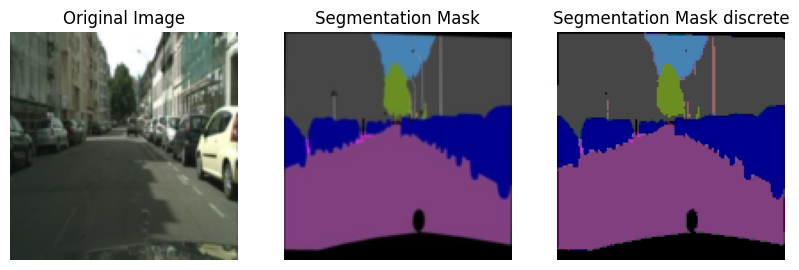

In [8]:
dataset = SemanticSegmentationDataset("/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/",
            resize=128,
            saved_masks_path="/kaggle/input/cv-lab4-discrete-masks/masks_array_train.npy")
original_image, mask = dataset[4]
img_mask = dataset.get_mask_image(4)
# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_mask)
plt.title('Segmentation Mask')
plt.axis('off')

output_image = visualize_segmentation(mask.numpy())

plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title('Segmentation Mask discrete')
plt.axis('off')

plt.show()

## Define transformers for data

In [9]:
# # Calculate mean and std of test and train sets
# traindata = SemanticSegmentationDataset(folder_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/', resize=128, saved_masks_path="/kaggle/input/cv-lab4-discrete-masks/masks_array_train.npy")
# testdata = SemanticSegmentationDataset(folder_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/', resize=128, saved_masks_path="/kaggle/input/cv-lab4-discrete-masks/masks_array_val.npy")
# mean_trn = traindata.mean()
# std_trn = traindata.std()
# mean_tst = testdata.mean()
# std_tst = testdata.std()

# np.save("mean_trn.npy", mean_trn)
# np.save("std_trn.npy", std_trn)
# np.save("mean_tst.npy", mean_tst)
# np.save("std_tst.npy", std_tst)

mean_trn = np.load("/kaggle/input/cv-lab4-discrete-masks/mean_trn.npy")
std_trn = np.load("/kaggle/input/cv-lab4-discrete-masks/std_trn.npy")
mean_tst = np.load("/kaggle/input/cv-lab4-discrete-masks/mean_tst.npy")
std_tst = np.load("/kaggle/input/cv-lab4-discrete-masks/std_tst.npy")

# Create sequence of transformations:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # resize to 128 x 128
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), # resize to 128 x 128
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst)
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# # Clear memory
# del traindata
# del testdata
# gc.collect()

## Creating dataloaders for train and test datasets (no validation split due to no KFold cross-validation and GridSearch CV)

In [10]:
# Download training part of CityScapes dataset
trainset = SemanticSegmentationDataset(
    folder_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/',
    resize=128,
    saved_masks_path="/kaggle/input/cv-lab4-discrete-masks/masks_array_train.npy",
    transformer=transform_train)

# Create a sampler, that provides an iterable over train dataset (used in OrdinaryTraining)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0,
    worker_init_fn=seed_worker, generator=g_train)

# Download test part of CityScapes dataset
testset = SemanticSegmentationDataset(
    folder_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/',
    resize=128,
    saved_masks_path="/kaggle/input/cv-lab4-discrete-masks/masks_array_val.npy",
    transformer=transform_test)

# Create a sampler for testset (used in OrdinaryTraining)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0,
    worker_init_fn=seed_worker, generator=g_test)

100%|██████████| 500/500 [00:03<00:00, 130.35it/s]


# Data visualization

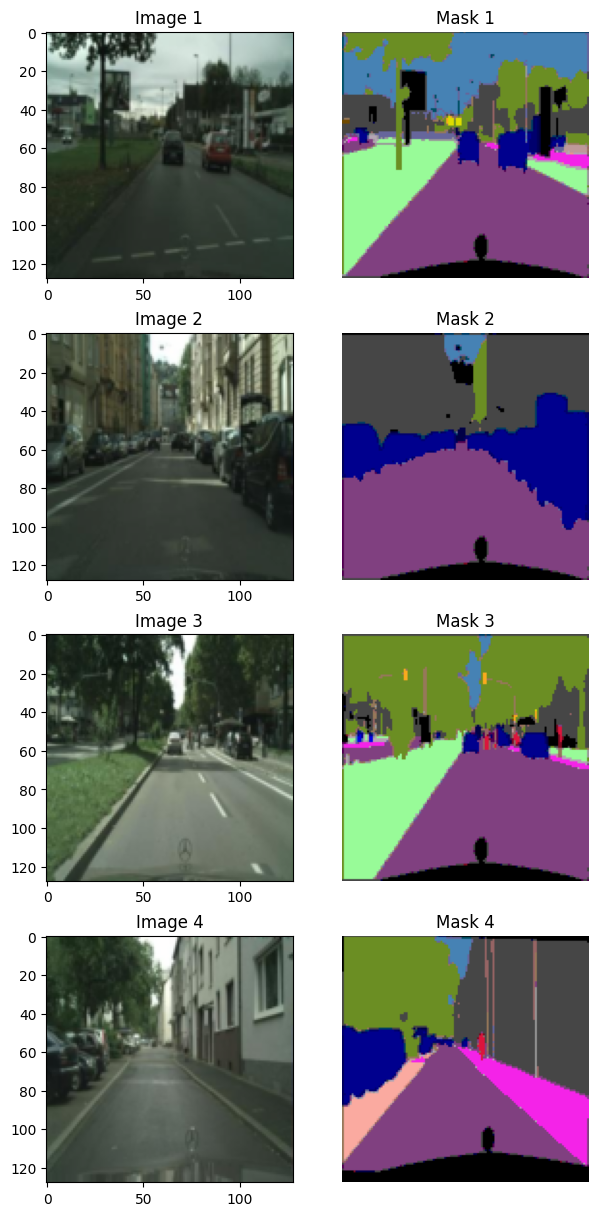

In [11]:
def imshow(img, title=None, unnorm=True):
    if unnorm: # Unnormalize image (we don't unnormalize mask)
        img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    plt.imshow(img.permute(1, 2, 0))
    if title is not None:
        plt.title(title)
        
# Get some training images
dataiter = iter(train_loader)
images, masks = next(dataiter)

# Show images and masks in a grid 4x2
fig = plt.figure(figsize=(7, 15))
rows, cols = 4, 2
for i in range(0, rows):
    img, mask = images[i], torchvision.transforms.functional.pil_to_tensor(visualize_segmentation(masks[i]))
    fig.add_subplot(rows, cols, 2 * i + 1)
    imshow(img, f"Image {i + 1}") # plot image
    fig.add_subplot(rows, cols, 2 * (i + 1))
    imshow(mask, f"Mask {i + 1}", False) # plot image mask
    plt.axis(False)

# Class for segmantation metrics computation
## Metrics computed for each class separately and then averaged:
### - Pixel accuracy <br>
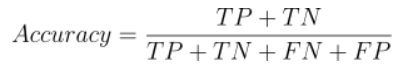
### - Dice score (main metric) <br>
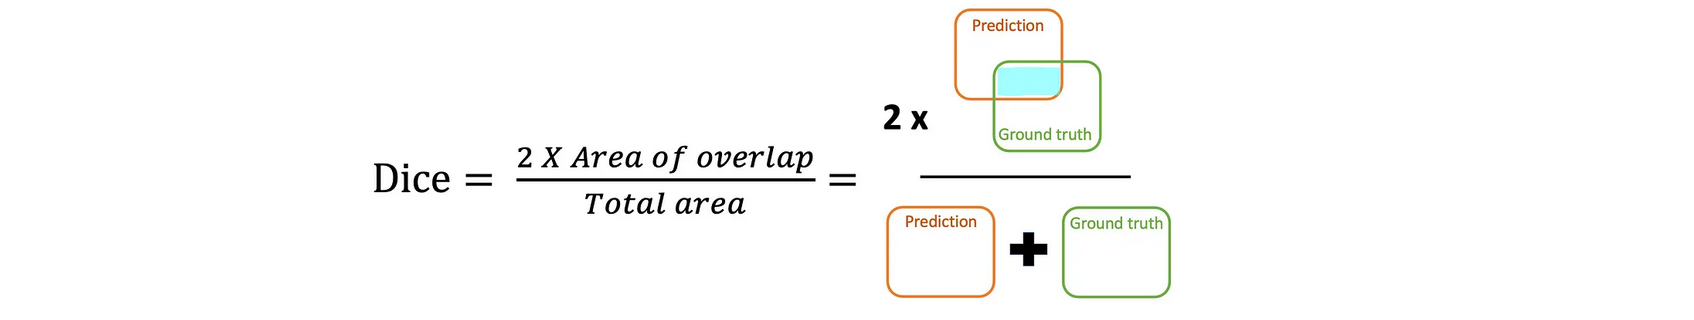
### - Precision <br>
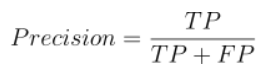
### - Recall <br>
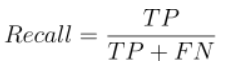

In [12]:
# Source: https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch/blob/master/metric.py
class SegmentationMetrics(object):
    r"""Calculate common metrics in semantic segmentation to evalueate model preformance.

    Supported metrics: Pixel accuracy, Dice Coeff, precision score and recall score.
    
    Pixel accuracy measures how many pixels in a image are predicted correctly.

    Dice Coeff is a measure function to measure similarity over 2 sets, which is usually used to
    calculate the similarity of two samples. Dice equals to f1 score in semantic segmentation tasks.
    
    It should be noted that Dice Coeff and Intersection over Union are highly related, so you need 
    NOT calculate these metrics both, the other can be calcultaed directly when knowing one of them.

    Precision describes the purity of our positive detections relative to the ground truth. Of all
    the objects that we predicted in a given image, precision score describes how many of those objects
    actually had a matching ground truth annotation.

    Recall describes the completeness of our positive predictions relative to the ground truth. Of
    all the objected annotated in our ground truth, recall score describes how many true positive instances
    we have captured in semantic segmentation.

    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5

        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.

        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.

        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.

    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.

    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, precision, recall = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        # tp = np.sum(matrix[0, :])
        # fp = np.sum(matrix[1, :])
        # fn = np.sum(matrix[2, :])

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps)
        precision = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + self.eps)
        recall = (matrix[0] + self.eps) / (matrix[0] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            precision = np.average(precision)
            recall = np.average(recall)

        return pixel_acc, dice, precision, recall

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, precision, recall = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, precision, recall

# Class, that creates abstraction for model, dataloaders, optimizer, criterion, etc., and allows to train and test this model as well as save checkpoint and plot graphs of loss and metrics

In [13]:
class OrdinaryTraining:
    def __init__(self, model, optimizer, lr_scheduler, criterion, accuracy, train_loader, test_loader, device, save_dir_prefix="", checkpoint_dir=None):
        """
        Parameters
        ----------
        model :
            CNN architecture model, already created and sent to device
        optimizer :
            Already instantiated optimizer
        lr_scheduler :
            Optimizer learning rate scheduler
        criterion :
            Already instantiated criterion
        accuracy :
            Already instantiated accuracy
        train_loader :
            Batch loader of train data
        test_loader :
            Batch loader of test data
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to directory where checkpoint state lies
        """
        
        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler
        self.accuracy = accuracy
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.train_batches_num = len(train_loader)
        self.test_batches_num = len(test_loader)
        self.model = model
        
        # Load training model from checkpoint
        if checkpoint_dir is not None:
            checkpoint = torch.load(checkpoint_dir)
            self.start_epoch = checkpoint['current_epoch'] + 1
            print(f"Loading OrdinaryTraining model from checkpoint trained for {self.start_epoch} epochs...")

            self.model.load_state_dict(checkpoint['model_param'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state'])
            self.lr_scheduler.load_state_dict(checkpoint['scheduler_state'])
            self.best_score = checkpoint['best_score']
            
            # Load loss and metrics arrays
            self.train_loss_arr = checkpoint['train_loss_arr']
            self.val_loss_arr = checkpoint['val_loss_arr']
            self.val_pixel_accuracy_arr = checkpoint['val_pixel_accuracy_arr']
            self.val_dice_score_arr = checkpoint['val_dice_score_arr']
            self.val_precision_arr = checkpoint['val_precision_arr']
            self.val_recall_arr = checkpoint['val_recall_arr']
            
            # Load environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            
        # Create blank training model
        else:
            print("Creating OrdinaryTraining model from scratch...")
            self.start_epoch = 0
            self.best_score = 0
            # Create required arrays to store loss and accuracy
            self.train_loss_arr = []
            self.val_loss_arr = []
            self.val_pixel_accuracy_arr = []
            self.val_dice_score_arr = []
            self.val_precision_arr = []
            self.val_recall_arr = []
        print(f"Model successfully created! Current start_epoch={self.start_epoch + 1}")
        self.checkpoint_directory = f'{type(self.model).__name__}_Ordinary_checkpoints'
        if save_dir_prefix != "":
            self.checkpoint_directory += "_" + save_dir_prefix
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=40):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        cycle_batch :  optional
            The number that determines after which amount of batches in each epoch information will be displayed
        """
        # Define flag for info display
        print_ind = False
        
        ##### Training for epochs #####
        # Create training and validation loop
        print(f"Training model for {epochs} epochs from {self.start_epoch + 1} to"
              f" {self.start_epoch + epochs}.")
        for epoch in range(self.start_epoch, self.start_epoch + epochs):
            global_print = (epoch + 1) % cycle_epoch == 0
            if global_print:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_loss = val_pix_acc = val_dscore = val_prec = val_rec = 0
            # Set network to train mode
            self.model.train()

            # Add a loop through training batches
            for batch_num, (tr_inputs, tr_masks) in enumerate(self.train_loader):
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(device)
                tr_masks = tr_masks.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                outputs = self.model(tr_inputs).to(device)
                loss = self.criterion(outputs, tr_masks)
                loss.requires_grad_()
                loss.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss

                # Print out how many samples have been seen
                # Output loss each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * batch_size} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del tr_masks
                del outputs
            ##### Training end #####

            self.lr_scheduler.step()  # Update learning rate
            
            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_masks in self.test_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(device)
                    val_masks = val_masks.to(device)
                    predictions = self.model(val_inputs).to(device)
                    
                    # Test loss and metrics calculation
                    val_loss += self.criterion(predictions, val_masks)
                    temp_pix_acc, temp_dscore, temp_prec, temp_rec = self.accuracy(val_masks, predictions)
                    val_pix_acc += temp_pix_acc
                    val_dscore += temp_dscore
                    val_prec += temp_prec
                    val_rec += temp_rec

                    # Clearing memory
                    del val_inputs
                    del val_masks
                    del predictions
                    del temp_pix_acc
                    del temp_dscore
                    del temp_prec
                    del temp_rec
            ##### Validation end #####

                # Save average (throughout the epoch) loss and metrics
                self.train_loss_arr.append(train_loss.item() / self.train_batches_num)
                self.val_loss_arr.append(val_loss.item() / self.test_batches_num)
                self.val_pixel_accuracy_arr.append(val_pix_acc / self.test_batches_num)
                self.val_dice_score_arr.append(val_dscore / self.test_batches_num)
                self.val_precision_arr.append(val_prec / self.test_batches_num)
                self.val_recall_arr.append(val_rec / self.test_batches_num)
                
                # Check if length of arrays is appropriate
                assert len(self.train_loss_arr)==len(self.val_loss_arr)== \
                    len(self.val_pixel_accuracy_arr)==len(self.val_dice_score_arr)== \
                    len(self.val_precision_arr)==len(self.val_recall_arr)
                assert epoch + 1 == len(self.train_loss_arr)
                
                if global_print:
                    # Print out average loss and accuracy of this epoch each cycle_epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}\n"
                          f"Average validation loss: {self.val_loss_arr[epoch]:.5f}\n"
                          f"Average validation pixel accuracy: {self.val_pixel_accuracy_arr[epoch]:.5f}\n"
                          f"Average validation dice score: {self.val_dice_score_arr[epoch]:.5f}\n"
                          f"Average validation precision: {self.val_precision_arr[epoch]:.5f}\n"
                          f"Average validation recall: {self.val_recall_arr[epoch]:.5f}\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                if self.best_score < self.val_dice_score_arr[epoch]:
                    if global_print:
                        print(f'\nSaving {epoch+1} status:\'best\' checkpoint, '
                              f'current dice score: {self.val_dice_score_arr[epoch]:.5f} is '
                              f'better than previous best result: {self.best_score:.5f}')
                    self.best_score = self.val_dice_score_arr[epoch]
                    self.checkpoint(epoch, 'best', global_print)
                else:
                    if global_print:
                        print(f'\nSaving {epoch+1} status:\'last\' checkpoint, '
                              f'current dice score: {self.val_dice_score_arr[epoch]:.5f}')
                    self.checkpoint(epoch, 'last', global_print)
                    
            # Garbage collection     
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####
        self.start_epoch += epochs # Save current epoch to start new training from it
    

    def checkpoint(self, current_epoch, status, print_flag=True):
        """ Save current_epoch checkpoint """
        state = {
            'model_param': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'scheduler_state': self.lr_scheduler.state_dict(),
            'current_epoch': current_epoch,
            'best_score': self.best_score,
            'train_loss_arr': self.train_loss_arr,
            'val_loss_arr': self.val_loss_arr,
            'val_pixel_accuracy_arr': self.val_pixel_accuracy_arr,
            'val_dice_score_arr': self.val_dice_score_arr,
            'val_precision_arr': self.val_precision_arr,
            'val_recall_arr': self.val_recall_arr,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }
        
        if not os.path.isdir(self.checkpoint_directory):
            os.mkdir(self.checkpoint_directory)
            
        torch.save(state, './'+ self.checkpoint_directory +\
                   f'/{status}_cpt')
        if print_flag:
            print(f'Successfully saved epoch {current_epoch + 1} status:{status} checkpoint!\n')
    
    
    def model_test(self): # Doesn't perform test in usual sense, because it uses the same validation set, that was used during training
        test_loss = test_pix_acc = test_dscore = test_prec = test_rec = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_masks in self.test_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(device)
                test_masks = test_masks.to(device)
                predictions = self.model(test_inputs).to(device)

                # Test loss and metrics calculation
                test_loss += self.criterion(predictions, test_masks)
                temp_pix_acc, temp_dscore, temp_prec, temp_rec = self.accuracy(test_masks, predictions)
                test_pix_acc += temp_pix_acc
                test_dscore += temp_dscore
                test_prec += temp_prec
                test_rec += temp_rec

                # Clearing memory
                del test_inputs
                del test_masks
                del predictions
                del temp_pix_acc
                del temp_dscore
                del temp_prec
                del temp_rec
        ##### Test end #####

            # Save average (throughout the epoch) loss and accuracy
            test_loss_score = test_loss / self.test_batches_num
            test_pixel_accuracy_arr = test_pix_acc / self.test_batches_num
            test_dice_score_arr = test_dscore / self.test_batches_num
            test_precision_arr = test_prec / self.test_batches_num
            test_recall_arr = test_rec / self.test_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        print(f"Test loss: {test_loss_score}")
        print(f"Test pixel accuracy: {test_pixel_accuracy_arr}")
        print(f"Test dice score: {test_dice_score_arr}")
        print(f"Test precision: {test_precision_arr}")
        print(f"Test recall: {test_recall_arr}")
        
    
    def plot_loss_acc(self):
        """
        Plot loss plots for train and validations sets and metrics plot for validation set.
        Works with latest epochs, train and val loss and val accuracy value and arrays respectively.
        """
        # Check if length of arrays is appropriate
        assert len(self.train_loss_arr)==len(self.val_loss_arr)== \
            len(self.val_pixel_accuracy_arr)==len(self.val_dice_score_arr)== \
            len(self.val_precision_arr)==len(self.val_recall_arr)
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, len(self.train_loss_arr) + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, self.train_loss_arr, 'r', label='Average train loss')
        plt.plot(epoch_arr, self.val_loss_arr,'b', label='Average validation loss')
        plt.title("Average loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, self.val_pixel_accuracy_arr,'blue', label='Average pixel accuracy')
        plt.plot(epoch_arr, self.val_dice_score_arr,'red', label='Average dice score')
        plt.plot(epoch_arr, self.val_precision_arr,'black', label='Average precision')
        plt.plot(epoch_arr, self.val_recall_arr,'yellow', label='Average recall')
        plt.title("Average validation metric value")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Metrics value")
        plt.show()
     
    
    def produce_masks(self, image_ind_list, dataset):
        """
        Generates masks for images with indexes of image_ind_list from dataset
        with the use of self.model, and then displays them in a grid, together
        with correct masks
        """
        original_images, masks = dataset[image_ind_list] # get images and masks
        predicted_masks = self.model(original_images.to(device)).to("cpu") # generate masks
        # Unnormalize images
        original_images = original_images * std_trn[None, :, None, None] + mean_trn[None, :, None, None]
        rows_num = len(image_ind_list)
        
        for ind, (original_image, mask, predicted_mask) in enumerate(zip(original_images, masks, predicted_masks)):
            # Display the images
            plt.figure(figsize=(10, 5*rows_num))
            plt.subplot(rows_num, 3, 3*ind+1)
            plt.imshow(original_image.permute(1, 2, 0))
            plt.title(f'Original Image {ind+1}')
            plt.axis('off')

            original_image_img = torchvision.transforms.functional.to_pil_image(original_image)
            original_mask_img = visualize_segmentation(mask.detach().numpy())

            plt.subplot(rows_num, 3, 3*ind+2)
            plt.imshow(OrdinaryTraining.overlay_segmentation(original_image_img, original_mask_img))
            # plt.imshow(original_mask_img)
            plt.title(f'Original Mask {ind+1}')
            plt.axis('off')

            predicted_mask_img = visualize_segmentation(torch.argmax(predicted_mask, dim=0).detach().numpy())

            plt.subplot(rows_num, 3, 3*ind+3)
            plt.imshow(OrdinaryTraining.overlay_segmentation(original_image_img, predicted_mask_img))
            # plt.imshow(predicted_mask_img)
            plt.title(f'Predicted Mask {ind+1}')
            plt.axis('off')

            plt.show()
    
    
    @staticmethod
    def overlay_segmentation(original_image, segmentation_mask, transparency=0.25):
        # Convert segmentation mask to RGBA mode
        segmentation_mask_rgba = segmentation_mask.convert('RGBA')
        # Create a new image with the same size as the original image
        result_image = PIL.Image.new('RGBA', original_image.size)
        # Blend the original image and segmentation mask
        result_image = PIL.Image.alpha_composite(result_image, original_image.convert('RGBA'))
        # Blend the segmentation mask with transparency
        result_image = PIL.Image.alpha_composite(result_image, PIL.Image.blend(segmentation_mask_rgba, PIL.Image.new('RGBA', original_image.size, (0, 0, 0, 0)), transparency))
        # Convert the result back to RGB mode
        result_image = result_image.convert('RGB')
        return result_image

# U-Net
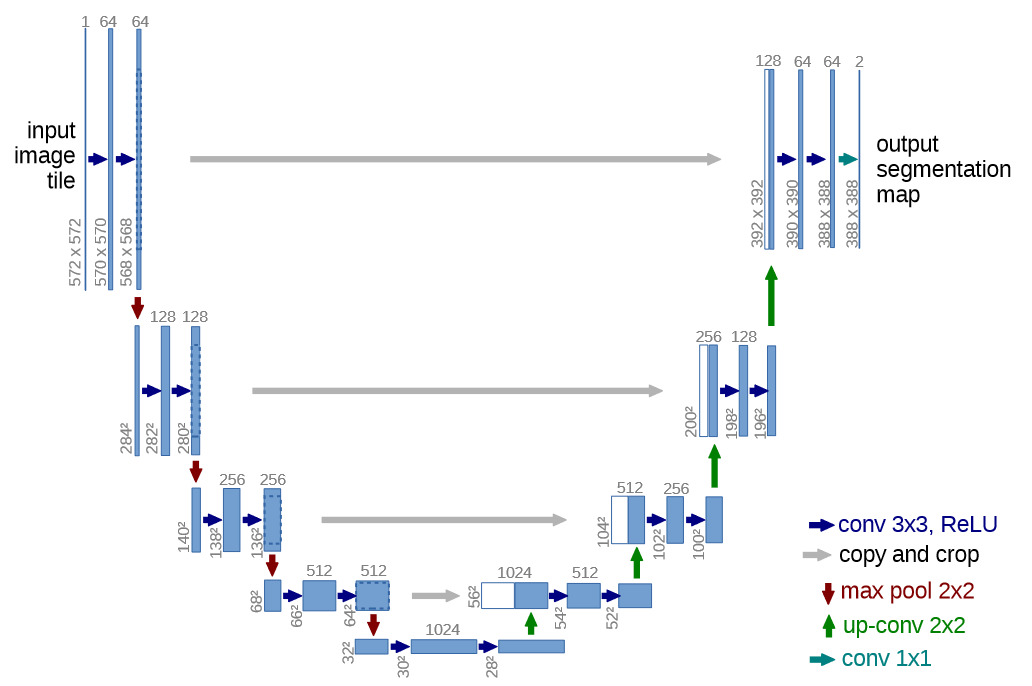

In [14]:
class DoubleConv(nn.Module):
    """ (Conv2d => BatchNorm => ReLU) x 2  """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down_conv(x)


class Up(nn.Module):
    """ Upscaling with ConvTranspose2d then double conv """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, decoder_part, encoder_part):
        decoder_part = self.up(decoder_part)
#         height_diff = decoder_part.size()[2] - encoder_part.size()[2]
#         width_diff = decoder_part.size()[3] - encoder_part.size()[3]

#         encoder_part = F.pad(encoder_part, [width_diff // 2, width_diff - width_diff // 2,
#                         height_diff // 2, height_diff - height_diff // 2])
        
#         x = torch.cat([Up.crop(encoder_part, decoder_part), decoder_part], dim=1)
        x = torch.cat([encoder_part, decoder_part], dim=1)
        return self.double_conv(x)

#     @staticmethod
#     def crop(encoder_part, decoder_part):
#         # grab the dimensions of the inputs, and crop the encoder
#         # features to match the dimensions
#         _, _, H, W = decoder_part.shape
#         encoder_part_cropped = torchvision.transforms.CenterCrop([H, W])(encoder_part)
#         # return the cropped features
#         return encoder_part_cropped

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.encoder1 = DoubleConv(n_channels, 64)
        self.encoder2 = Down(64, 128)
        self.encoder3 = Down(128, 256)
        self.encoder4 = Down(256, 512)
        
        self.bottle_neck = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # checkpointing is used to save memory
        x_e1 = checkpoint(self.encoder1, x, use_reentrant=False)
        x_e2 = checkpoint(self.encoder2, x_e1, use_reentrant=False)
        x_e3 = checkpoint(self.encoder3, x_e2, use_reentrant=False)
        x_e4 = checkpoint(self.encoder4, x_e3, use_reentrant=False)
        x_bn = checkpoint(self.bottle_neck, x_e4, use_reentrant=False)
        x_bn = checkpoint(self.up1, x_bn, x_e4, use_reentrant=False)
        x_bn = checkpoint(self.up2, x_bn, x_e3, use_reentrant=False)
        x_bn = checkpoint(self.up3, x_bn, x_e2, use_reentrant=False)
        x_bn = checkpoint(self.up4, x_bn, x_e1, use_reentrant=False)
        logits = checkpoint(self.out_conv, x_bn, use_reentrant=False)
        return logits

# Network training with U-Net and CityScapes

In [15]:
# Set up loss criterion (used in OrdinaryTraining)
criterion = nn.CrossEntropyLoss()
# Set up accuracy metrics class
accuracy = SegmentationMetrics(average=True, ignore_background=True)

In [29]:
# Instantiate UNet model and send to GPU
unet = UNet(n_channels=3, n_classes=len(SemanticSegmentationDataset.id_map)).to(device)

# Declare optimizer
optimizer = optim.SGD(unet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Learning_rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

# Create Training model
unet_model = OrdinaryTraining(unet, optimizer, lr_scheduler, criterion, accuracy, train_loader,
                            test_loader, device,
                            checkpoint_dir="/kaggle/input/cv-lab4-checkpoints/SGD_CosineAnneal5_epoch_20_best(20)_cpt")

print(f"Amount of batches processed in each epoch during full ordinary training: {len(train_loader)}")

Loading OrdinaryTraining model from checkpoint trained for 20 epochs...
Model successfully created! Current start_epoch=21
Amount of batches processed in each epoch during full ordinary training: 92


In [33]:
# train for 10 more epochs
unet_model.train_validate_cycle(epochs=10, cycle_epoch=4)

Training model for 10 epochs from 46 to 55.
Current epoch: 48
-------
Looked at 1248 samples
Current train loss for batch: 0.279634028673172
Looked at 2528 samples
Current train loss for batch: 0.2595135271549225

Average train loss: 0.27704
Average validation loss: 0.76778
Average validation pixel accuracy: 0.80800
Average validation dice score: 0.33547
Average validation precision: 0.44014
Average validation recall: 0.32845


Saving 48 status:'best' checkpoint, current dice score: 0.33547 is better than previous best result: 0.33533
Successfully saved epoch 48 status:best checkpoint!

Current epoch: 52
-------
Looked at 1248 samples
Current train loss for batch: 0.23821862041950226
Looked at 2528 samples
Current train loss for batch: 0.25242921710014343

Average train loss: 0.26793
Average validation loss: 0.80156
Average validation pixel accuracy: 0.80547
Average validation dice score: 0.33271
Average validation precision: 0.39644
Average validation recall: 0.31965


Saving 52 statu

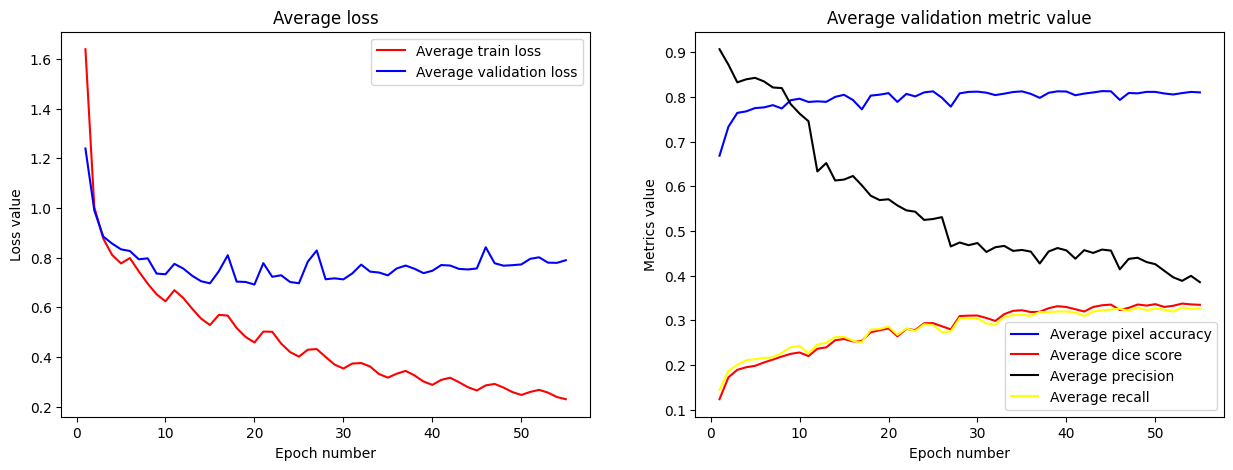

In [34]:
unet_model.plot_loss_acc()

In [37]:
unet_model = OrdinaryTraining(unet, optimizer, lr_scheduler, criterion, accuracy, train_loader,
                            test_loader, device,
                            checkpoint_dir="/kaggle/working/UNet_Ordinary_checkpoints/best_cpt")

Loading OrdinaryTraining model from checkpoint trained for 53 epochs...
Model successfully created! Current start_epoch=54


In [38]:
unet_model.model_test()

Test loss: 0.7800418734550476
Test pixel accuracy: 0.8085863318043275
Test dice score: 0.3375649011669757
Test precision: 0.3884344277476246
Test recall: 0.3289872099212025


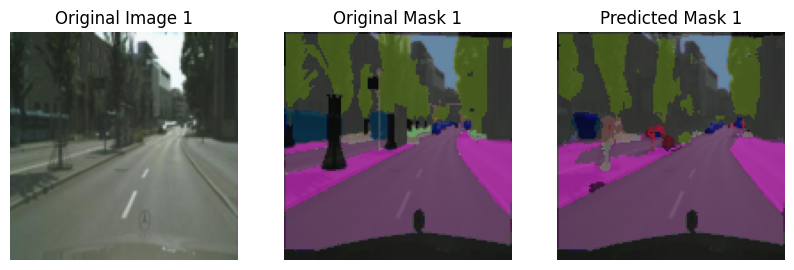

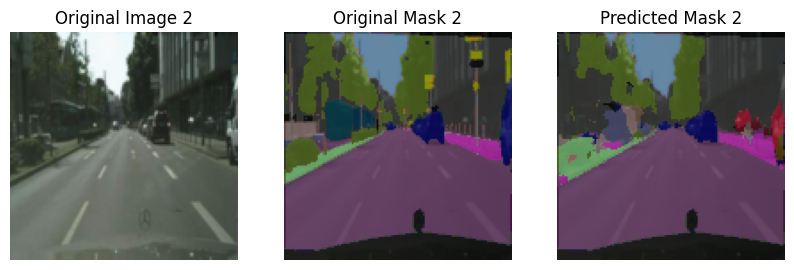

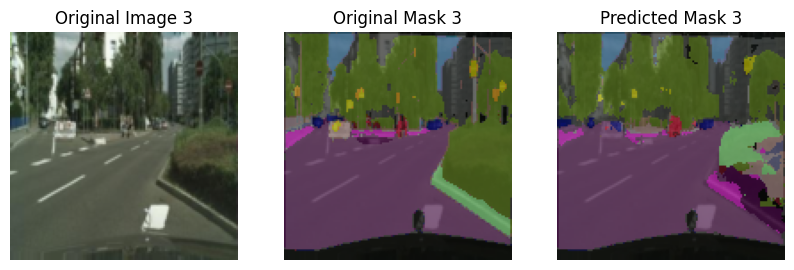

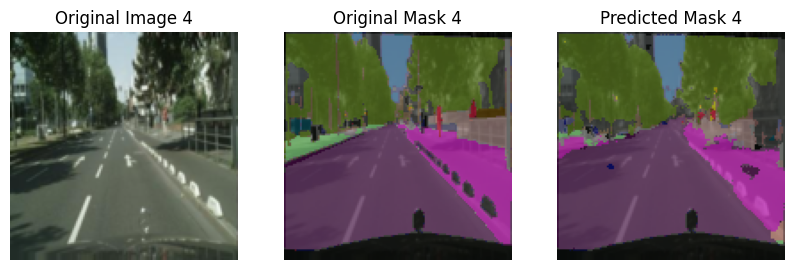

In [39]:
unet_model.produce_masks(image_ind_list=[0,5,10,15], dataset=testset)

In [23]:
# Instantiate UNet model and send to GPU
unet3 = UNet(n_channels=3, n_classes=len(SemanticSegmentationDataset.id_map)).to(device)

# Declare optimizer
optimizer3 = optim.SGD(unet3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Learning_rate scheduler
lr_scheduler3 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer3, T_0=9)

# Create Training model
unet_model3 = OrdinaryTraining(unet3, optimizer3, lr_scheduler3, criterion, accuracy, train_loader,
                              test_loader, device)

Creating OrdinaryTraining model from scratch...
Model successfully created! Current start_epoch=1


In [24]:
# train for 50 epochs
unet_model3.train_validate_cycle(epochs=50, cycle_epoch=10)

Training model for 50 epochs from 1 to 50.
Current epoch: 10
-------
Looked at 1248 samples
Current train loss for batch: 0.757327675819397
Looked at 2528 samples
Current train loss for batch: 0.7017034292221069

Average train loss: 0.71830
Average validation loss: 0.81807
Average validation pixel accuracy: 0.77023
Average validation dice score: 0.21366
Average validation precision: 0.72606
Average validation recall: 0.22459


Saving 10 status:'last' checkpoint, current dice score: 0.21366
Successfully saved epoch 10 status:last checkpoint!

Current epoch: 20
-------
Looked at 1248 samples
Current train loss for batch: 0.5886792540550232
Looked at 2528 samples
Current train loss for batch: 0.6547918915748596

Average train loss: 0.56855
Average validation loss: 0.77771
Average validation pixel accuracy: 0.78703
Average validation dice score: 0.25264
Average validation precision: 0.57945
Average validation recall: 0.24905


Saving 20 status:'last' checkpoint, current dice score: 0.25264

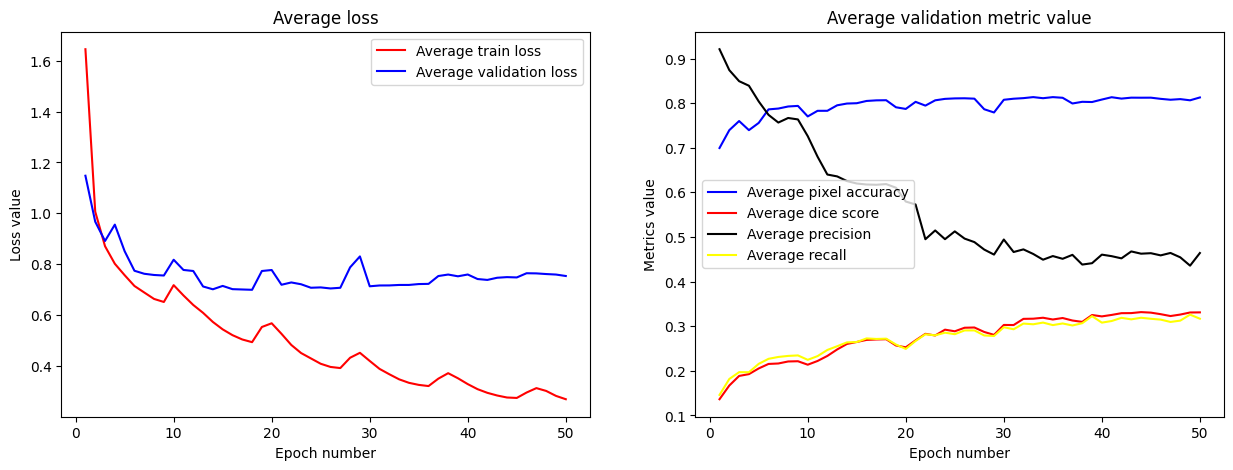

In [25]:
unet_model3.plot_loss_acc()

In [26]:
unet_model3 = OrdinaryTraining(unet3, optimizer3, lr_scheduler3, criterion, accuracy, train_loader,
                              test_loader, device,
                              checkpoint_dir="/kaggle/working/UNet_Ordinary_checkpoints/best_cpt")

Loading OrdinaryTraining model from checkpoint trained for 44 epochs...
Model successfully created! Current start_epoch=45


In [27]:
unet_model3.model_test()

Test loss: 0.7497562766075134
Test pixel accuracy: 0.8121913544050854
Test dice score: 0.33158119178657897
Test precision: 0.462545623707699
Test recall: 0.3189131873701425


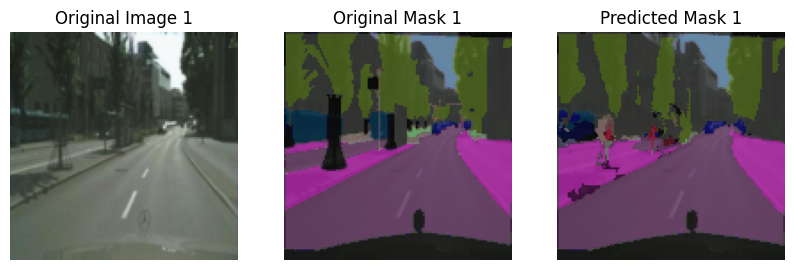

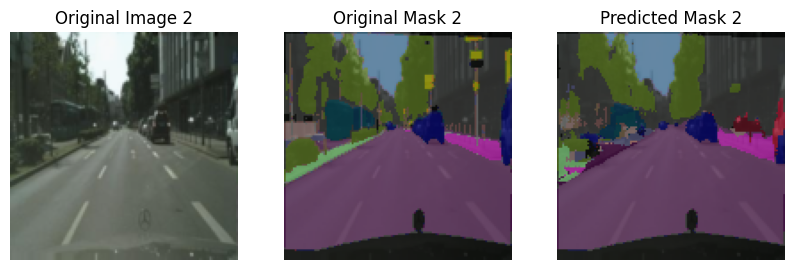

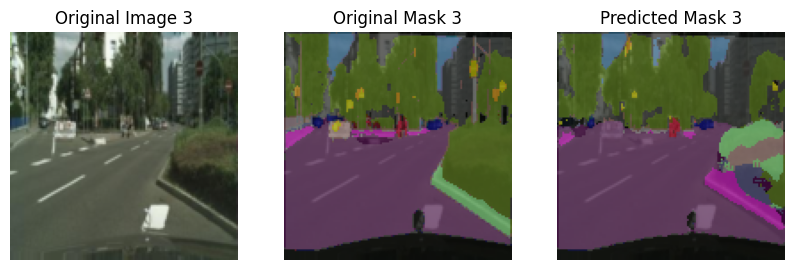

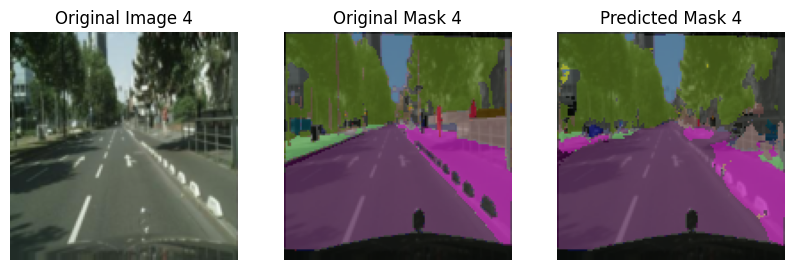

In [28]:
unet_model3.produce_masks(image_ind_list=[0,5,10,15], dataset=testset)

In [16]:
unet2 = UNet(n_channels=3, n_classes=len(SemanticSegmentationDataset.id_map)).to(device)

# Declare optimizer
optimizer2 = torch.optim.Adam(unet2.parameters(), weight_decay=1e-4)

# Learning_rate scheduler
lr_scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, [20, 35, 45])

# Create Training model
unet_model2 = OrdinaryTraining(unet2, optimizer2, lr_scheduler2, criterion, accuracy, train_loader,
                              test_loader, device, "Adam_MultiStepLR_60")

Creating OrdinaryTraining model from scratch...
Model successfully created! Current start_epoch=1


In [17]:
# train for 60 epochs
unet_model2.train_validate_cycle(epochs=60, cycle_epoch=10)

Training model for 60 epochs from 1 to 60.
Current epoch: 10
-------
Looked at 1248 samples
Current train loss for batch: 0.647470235824585
Looked at 2528 samples
Current train loss for batch: 0.6998225450515747

Average train loss: 0.61458
Average validation loss: 0.66199
Average validation pixel accuracy: 0.80453
Average validation dice score: 0.29167
Average validation precision: 0.63640
Average validation recall: 0.28213


Saving 10 status:'best' checkpoint, current dice score: 0.29167 is better than previous best result: 0.28146
Successfully saved epoch 10 status:best checkpoint!

Current epoch: 20
-------
Looked at 1248 samples
Current train loss for batch: 0.5656288862228394
Looked at 2528 samples
Current train loss for batch: 0.5080146789550781

Average train loss: 0.51877
Average validation loss: 0.60239
Average validation pixel accuracy: 0.82148
Average validation dice score: 0.35544
Average validation precision: 0.53254
Average validation recall: 0.33545


Saving 20 status:'

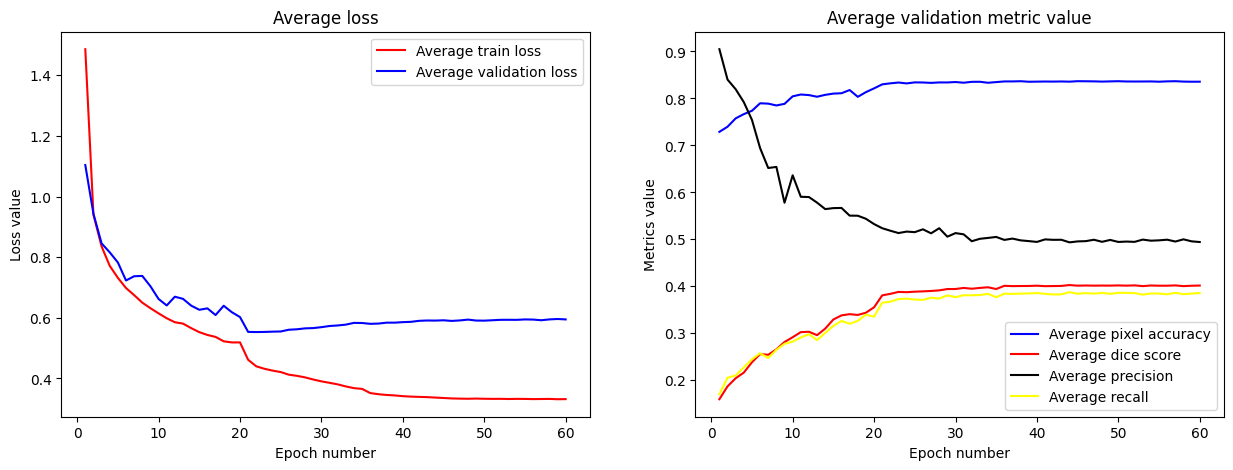

In [19]:
unet_model2.plot_loss_acc()

In [20]:
unet_model2 = OrdinaryTraining(unet2, optimizer2, lr_scheduler2, criterion, accuracy, train_loader,
                test_loader, device, save_dir_prefix="Adam_MultiStepLR_60",
                checkpoint_dir="/kaggle/working/UNet_Ordinary_checkpoints_Adam_MultiStepLR_60/best_cpt")

Loading OrdinaryTraining model from checkpoint trained for 44 epochs...
Model successfully created! Current start_epoch=45


In [22]:
unet_model2.model_test()

Test loss: 0.5907535552978516
Test pixel accuracy: 0.8357786683345612
Test dice score: 0.40272820025406963
Test precision: 0.4936601003849998
Test recall: 0.3875968570640852


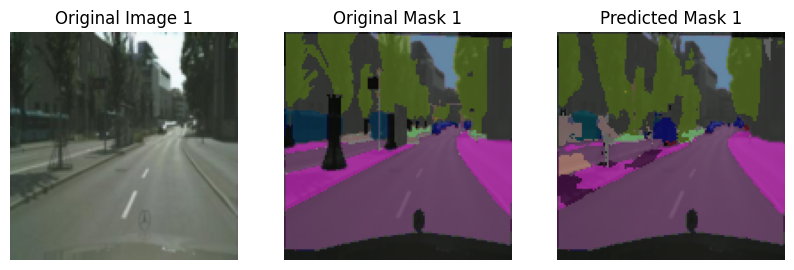

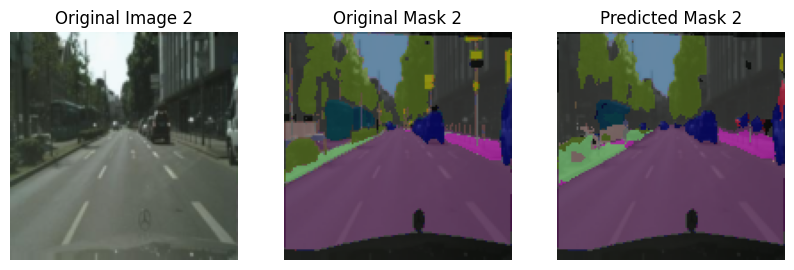

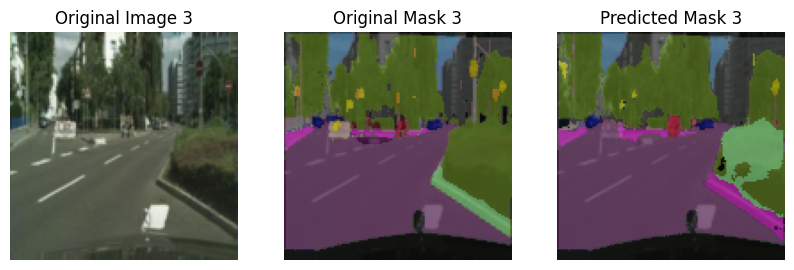

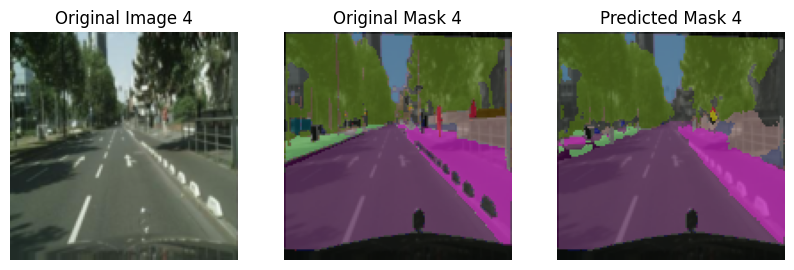

In [21]:
unet_model2.produce_masks(image_ind_list=[0,5,10,15], dataset=testset)

In [40]:
# Instantiate UNet model and send to GPU
unet4 = UNet(n_channels=3, n_classes=len(SemanticSegmentationDataset.id_map)).to(device)

# Declare optimizer
optimizer4 = optim.SGD(unet4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
# optimizer = Adam(unet.parameters(), lr=config.INIT_LR)

# Learning_rate scheduler
lr_scheduler4 = torch.optim.lr_scheduler.ExponentialLR(optimizer4, gamma=0.95)

# Create Training model
unet_model4 = OrdinaryTraining(unet4, optimizer4, lr_scheduler4, criterion, accuracy, train_loader,
                              test_loader, device)

Creating OrdinaryTraining model from scratch...
Model successfully created! Current start_epoch=1


In [41]:
# train for 45 epochs
unet_model4.train_validate_cycle(epochs=50, cycle_epoch=10)

Training model for 50 epochs from 1 to 50.
Current epoch: 10
-------
Looked at 1248 samples
Current train loss for batch: 0.6354709267616272
Looked at 2528 samples
Current train loss for batch: 0.6016346216201782

Average train loss: 0.61148
Average validation loss: 0.72068
Average validation pixel accuracy: 0.79723
Average validation dice score: 0.23902
Average validation precision: 0.64603
Average validation recall: 0.24316


Saving 10 status:'best' checkpoint, current dice score: 0.23902 is better than previous best result: 0.22973
Successfully saved epoch 10 status:best checkpoint!

Current epoch: 20
-------
Looked at 1248 samples
Current train loss for batch: 0.4067307710647583
Looked at 2528 samples
Current train loss for batch: 0.4534696936607361

Average train loss: 0.42798
Average validation loss: 0.72856
Average validation pixel accuracy: 0.80533
Average validation dice score: 0.28099
Average validation precision: 0.51028
Average validation recall: 0.27706


Saving 20 status:

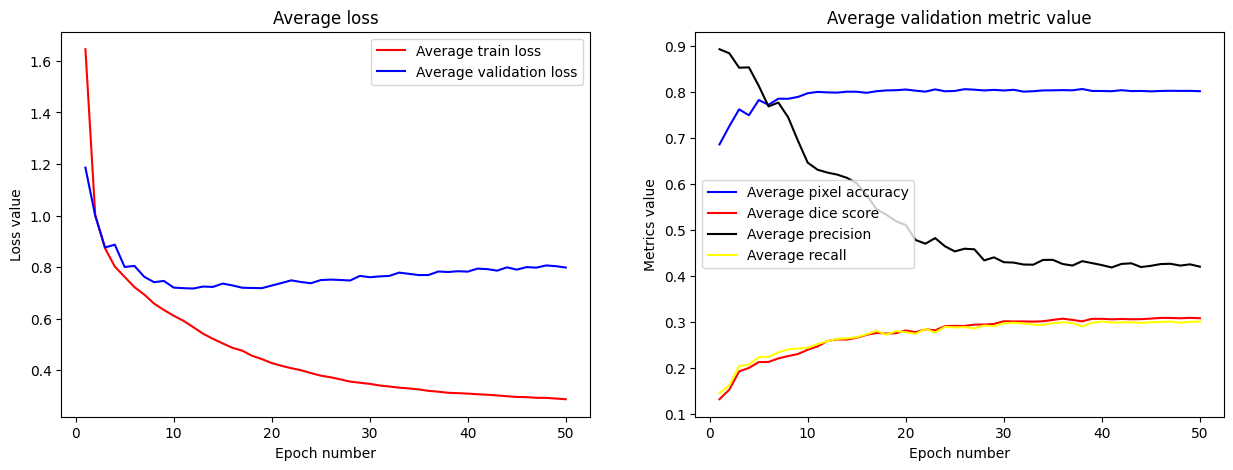

In [42]:
unet_model4.plot_loss_acc()

In [45]:
unet_model4 = OrdinaryTraining(unet4, optimizer4, lr_scheduler4, criterion, accuracy, train_loader,
                test_loader, device,
                checkpoint_dir="/kaggle/working/UNet_Ordinary_checkpoints/best_cpt")

Loading OrdinaryTraining model from checkpoint trained for 49 epochs...
Model successfully created! Current start_epoch=50


In [46]:
unet_model4.model_test()

Test loss: 0.803607165813446
Test pixel accuracy: 0.8024261468712319
Test dice score: 0.3084254372472584
Test precision: 0.4248772672887097
Test recall: 0.2998753585086986


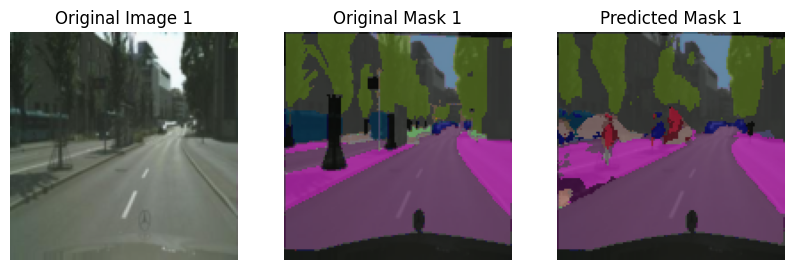

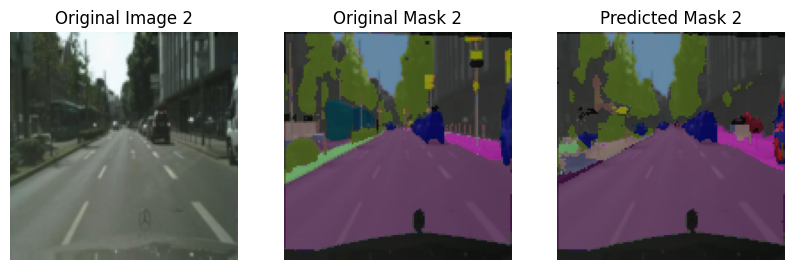

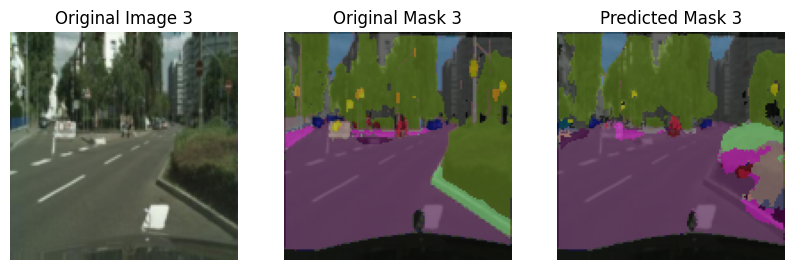

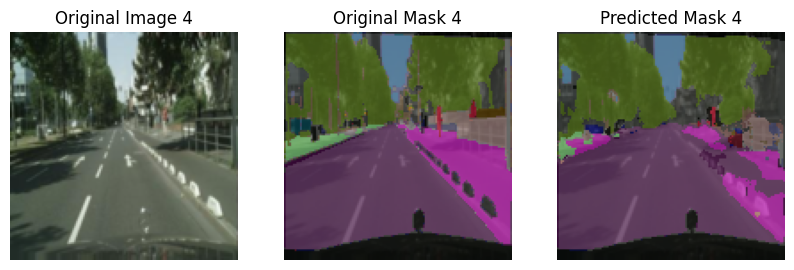

In [47]:
unet_model4.produce_masks(image_ind_list=[0,5,10,15], dataset=testset)

# Conclusions
## Results comparison:
|   | **Optimizer** | Lr scheduler                | Number of epochs | Best result epoch | **Dice score** | init lr | momentum | weight decay | add. params | pixel accuracy | precision | recall  | loss    |
|---|---------------|-----------------------------|------------------|-------------------|----------------|---------|----------|--------------|-------------|----------------|-----------|---------|---------|
| 1 | SGD           | ExponentialLR               | 50               | 49                | 0.30842        | 0.01    | 0.9      | 0.0001       | gamma=0.95  | 0.80243        | 0.42488   | 0.29988 | 0.80361 |
| 2 | SGD           | CosineAnnealingWarmRestarts | 55               | 53                | 0.33756        | 0.01    | 0.9      | 0.0001       | T_0=5       | 0.80859        | 0.38843   | 0.32899 | 0.78004 |
| 3 | SGD           | CosineAnnealingWarmRestarts | 50               | 44                | 0.33158        | 0.01    | 0.9      | 0.0001       | T_0=9       | 0.81219        | 0.46255   | 0.31891 | 0.74976 |
| 4 | Adam          | MultiStepLR                 | 60               | 44                | 0.40273        | 0.001   | -        | 0.0001       | default     | 0.83578        | 0.49366   | 0.3876  | 0.59075 |

### In this work Dice score was chosen as the main metric, because unlike pixel accuracy it incorporates Spatial Localization and it is also less sensitive to class disbalance problem. Judging by the experiments conducted in this work we can see that it takes little time(even with checkpointing part of the models) for this version of UNet (128x128 -> 128x128) to process one epoch. Unlike the classification task where we classify the whole image, here we get class label for each pixel (so first we need to convert mask from RGB format to height x width format, where each value is a label). As we can see from the table, Adam optimizer provided us the best dice score on the test set(this can also be seen on the mask generation demonstration + loss and other metrics values are better as well). Interesting result is that CosineAnnealingWarmRestarts with T_0=5 provided better dice score than ExponentialLR learning rate scheduler for SGD. The fact that Adam provided better results than SGD is because to get better results with SGD much more hyperparameters fine-tuning is required than with Adam.